In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/test-file/tested.csv


In [ ]:
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold
import xgboost as xgb


from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import cv

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('/kaggle/input/test-file/tested.csv')

In [ ]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
# 'PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
#        'AV_Survived'],    Cabin, Embarked, Sex

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Survived     418 non-null    int64  
 2   Pclass       418 non-null    int64  
 3   Name         418 non-null    object 
 4   Sex          418 non-null    object 
 5   Age          332 non-null    float64
 6   SibSp        418 non-null    int64  
 7   Parch        418 non-null    int64  
 8   Ticket       418 non-null    object 
 9   Fare         417 non-null    float64
 10  Cabin        91 non-null     object 
 11  Embarked     418 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB


### Deal with Missing Categorical Values

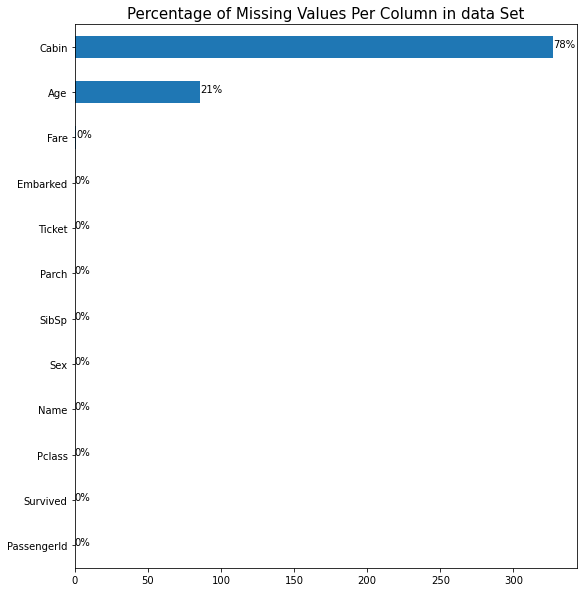

In [ ]:
# Check if there any missing values in train set
ax = df.isna().sum().sort_values().plot(kind = 'barh', figsize = (9, 10))
plt.title('Percentage of Missing Values Per Column in data Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/df.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

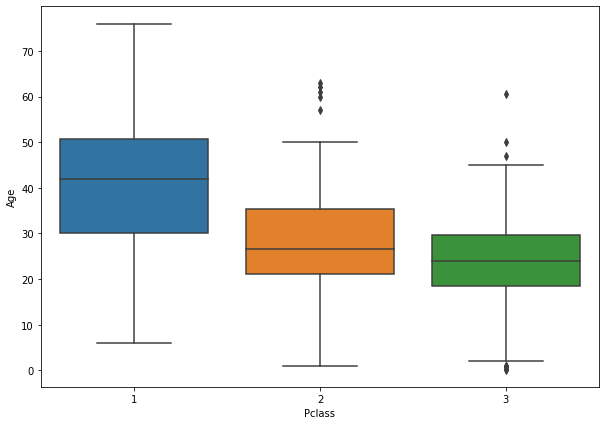

In [ ]:
plt.figure(figsize=(10,7))
sns.boxplot(x='Pclass', y='Age', data=df)

In [ ]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 37 
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age
        

In [ ]:
df['Age'] = df[['Age', 'Pclass']].apply(impute_age, axis=1)

<AxesSubplot:>

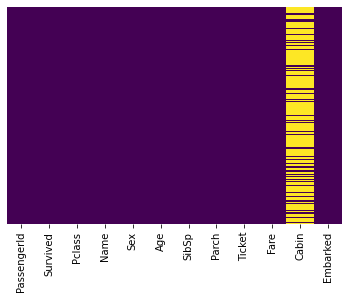

In [ ]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [ ]:
print(f"the number of unique Cabin: {df['Cabin'].nunique()}  \n \n {df['Cabin'].unique()}")

the number of unique Cabin: 76  
 
 [nan 'B45' 'E31' 'B57 B59 B63 B66' 'B36' 'A21' 'C78' 'D34' 'D19' 'A9'
 'D15' 'C31' 'C23 C25 C27' 'F G63' 'B61' 'C53' 'D43' 'C130' 'C132' 'C101'
 'C55 C57' 'B71' 'C46' 'C116' 'F' 'A29' 'G6' 'C6' 'C28' 'C51' 'E46' 'C54'
 'C97' 'D22' 'B10' 'F4' 'E45' 'E52' 'D30' 'B58 B60' 'E34' 'C62 C64' 'A11'
 'B11' 'C80' 'F33' 'C85' 'D37' 'C86' 'D21' 'C89' 'F E46' 'A34' 'D' 'B26'
 'C22 C26' 'B69' 'C32' 'B78' 'F E57' 'F2' 'A18' 'C106' 'B51 B53 B55'
 'D10 D12' 'E60' 'E50' 'E39 E41' 'B52 B54 B56' 'C39' 'B24' 'D28' 'B41'
 'C7' 'D40' 'D38' 'C105']


In [ ]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [ ]:
df['Fare'] = df["Fare"].fillna(df["Fare"].mean())


In [ ]:
sex = pd.get_dummies(df['Sex'], drop_first=True)

In [ ]:
embark = pd.get_dummies(df['Embarked'], drop_first=True)

In [ ]:
# pclass = pd.get_dummies(df['Pclass'], drop_first=True)

In [ ]:
data = pd.concat([df, sex, embark], axis=1)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,male,Q,S
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,1,1,0
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0,0,1
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,1,1,0
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,1,0,1
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0,0,1


In [ ]:
data = data.drop(['Sex', 'Embarked', 'Name'], axis=1)

In [ ]:
data = data.drop(['Cabin'], axis=1)

In [ ]:
df_permutated = data.sample(frac=1)

train_size = 0.8
train_end = int(len(df_permutated)*train_size)

train = df_permutated[:train_end]
test = df_permutated[train_end:]

In [ ]:
X_train = train
X_test = test

In [ ]:

#select the numerical features only
X_train = train.select_dtypes(include=['number']).copy()
X_test = test.select_dtypes(include=['number']).copy()


#drop the target column
X_train = X_train.drop(['Survived'], axis=1)
X_test = X_test.drop(['Survived'], axis=1)



# add the train/test labels
X_train["AV_Survived"] = 0
X_test["AV_Survived"] = 1

#combine the dataset
all_data = pd.concat([X_train, X_test], axis=0, ignore_index=True)


# shuffle
data_shuffled = all_data.sample(frac=1)

#create our DMatrix (the XGBoost data structure)
X =  data_shuffled.drop(['AV_Survived'], axis=1)
y =  data_shuffled['AV_Survived']
XGBdata = xgb.DMatrix(data=X, label=y)

#our XGBoost parameters
params = {
    "objective": "binary:logistic", 
    "eval_metric":"logloss",
    "learning_rate": 0.05,
    "max_depth": 5,
}

#perform cross validation with XGBoost
cross_val_results = cv(dtrain=XGBdata, params=params, 
                      nfold=5, metrics="auc", 
                      num_boost_round=200, early_stopping_rounds=20,
                      as_pandas=True)

#print out all the final results
print((cross_val_results['test-auc-mean']).tail(1))



20    0.53165
Name: test-auc-mean, dtype: float64


how relative variable importance is computed in Gradient Boosted Trees that is not overly general/simplistic like:

The measures are based on the number of times a variable is selected for splitting, weighted by the squared improvement to the model as a result of each split, and averaged over all trees. [Elith et al. 2008, A working guide to boosted regression trees]

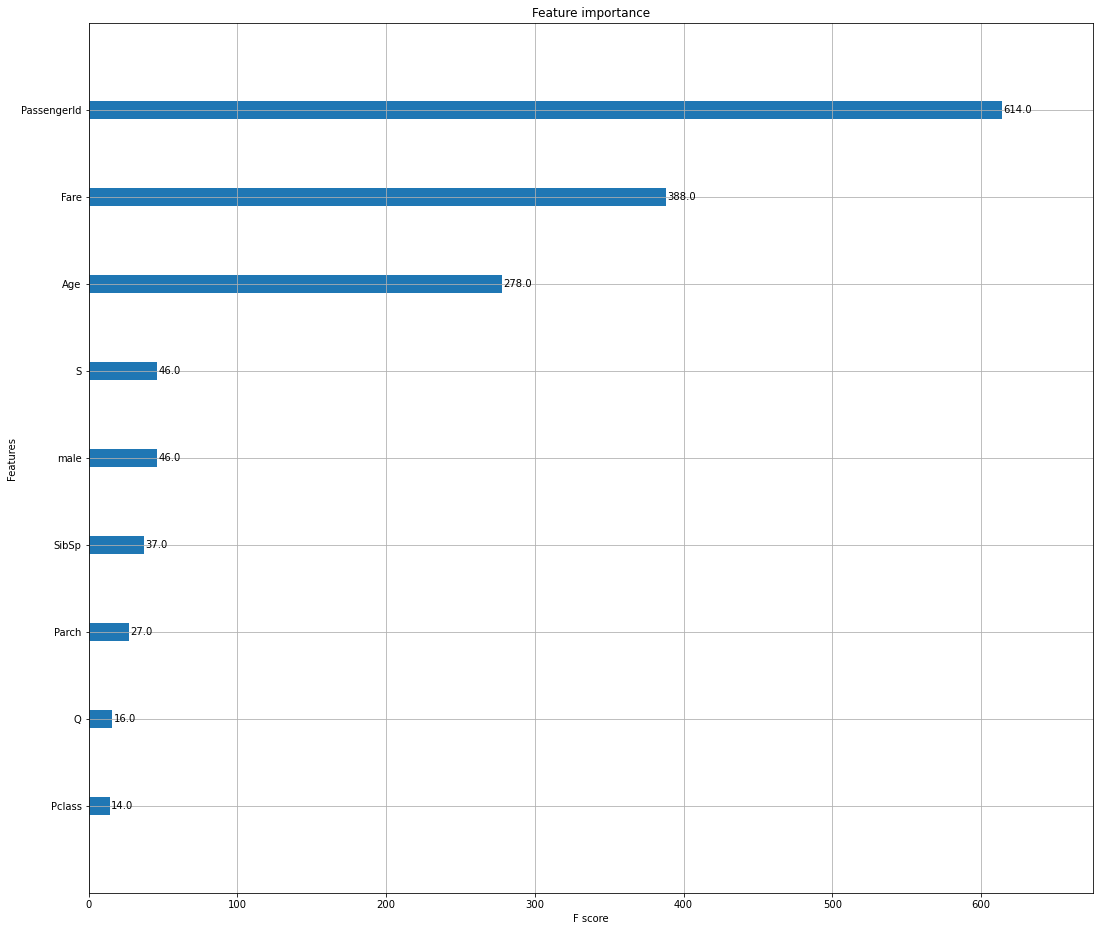

In [ ]:
classifier = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
classifier.fit(X, y)
fig, ax = plt.subplots(figsize=(18, 16))
plot_importance(classifier, ax=ax)
plt.show();


In [ ]:
X_train.columns

Index(['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'AV_Survived'],
      dtype='object')

In [ ]:
X = X.drop(['PassengerId'], axis=1)

In [ ]:
#create our DMatrix (the XGBoost data structure)=
XGBdata = xgb.DMatrix(data=X, label=y)

#perform cross validation with XGBoost
cross_val_results = cv(dtrain=XGBdata, params=params, 
                      nfold=5, metrics="auc", 
                      num_boost_round=200, early_stopping_rounds=20,
                      as_pandas=True)

#print out all the final results
print((cross_val_results['test-auc-mean']).tail(1))

11    0.475512
Name: test-auc-mean, dtype: float64
